# Arboles de decisión para clasificación



El conjunto de datos contiene la fecha, el precio de apertura, el precio de cierre y el máximo y el mínimo durante la sesión. También contiene numerosos indicadores financieros, la fecha desagregada en su información y la clase a predecir (si es el momento de invertir o no).

En este caso utilizaremos un conjunto de datos completo con un gran número de indicadores económicos para predecir el objetivo (SPY17VAR)

In [1]:
# 0. load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving SPY17VAR.csv to SPY17VAR.csv
User uploaded file "SPY17VAR.csv" with length 419694 bytes


In [2]:
import pandas as pd
import io
spy = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
spy.head()

,DATE,OPEN,MAX,MIN,CLOSE,CLASS,2,42,45,48,...,187,218,221,223,231,237,date.year,date.month,date.day-of-month,date.day-of-week
0,3/26/07,143.50,143.65,142.09,143.20,1,2.87,0.19,1.6351,1.3908,...,14.64,91.8447,23.43,3.3864,45418933114,4.7209,7,3,26,1
1,3/27/07,143.12,143.16,142.39,142.86,1,2.84,0.19,1.5526,1.3792,...,14.64,90.7010,23.49,0.7620,44525544754,1.6001,7,3,27,2
2,3/28/07,142.14,142.47,141.26,141.82,1,2.81,0.19,1.5573,1.3709,...,14.64,87.4706,22.92,-1.0962,43405039417,-1.4107,7,3,28,3
3,3/29/07,142.54,142.61,141.19,141.97,1,2.78,0.19,1.5436,1.3661,...,14.64,87.0782,22.75,-0.0015,43920769402,-0.2309,7,3,29,4
4,3/30/07,142.24,142.84,140.56,142.00,1,2.75,0.19,1.6172,1.3641,...,14.64,87.6430,22.75,0.2221,43709223713,-0.8835,7,3,30,5


Vamos a realizar un sencillo análisis exploratorio de datos. Por ejemplo, tenemos que responder a las preguntas sobre la distribución de las clases.

CLASS
0     650
1    2133
dtype: int64


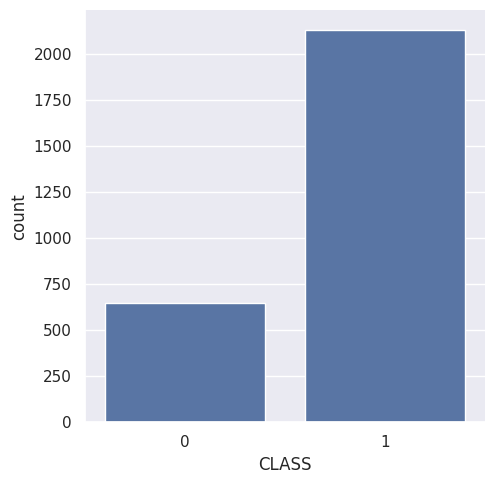

In [3]:
import seaborn as sb
sb.set(style='darkgrid')

print(spy.groupby('CLASS').size())

sb.catplot(x='CLASS', data=spy, kind='count')

Esto nos muestra que hay una cantidad desequilibrada de etiquetas en una proporción de 3,28 a 1 (76%-23%). Esta información debe tenerse en cuenta a la hora de crear el modelo mediante su equilibrado.

Vamos a utilizar también los **histogramas** agrupan los datos en intervalos y proporcionan un recuento del número de observaciones en cada intervalo. Esto es muy útil para identificar la distribución de los datos y también puede ayudar a ver posibles valores atípicos.

<Axes: xlabel='45', ylabel='Count'>

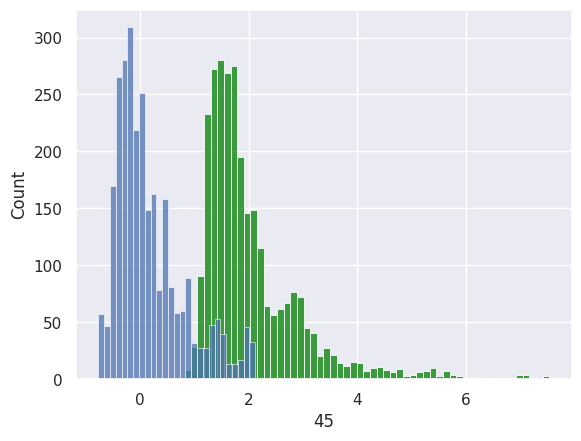

In [4]:

sb.histplot(spy['45'], color = "green")
sb.histplot(spy['171'])



Vamos a reducir el conjunto de datos a sólo tres variables lo cual resulta de análisis previos.


In [5]:
spy = spy[['45','75','171', 'CLASS']]
spy.head()

,45,75,171,CLASS
0,1.6351,14.54,-0.08,1
1,1.5526,15.58,-0.07,1
2,1.5573,14.55,-0.07,1
3,1.5436,14.40,-0.06,1
4,1.6172,14.33,-0.06,1


## Arboles de Decisión

Necesitamos optimizar algunos parámetros del Árbol de Decisión, en este ejemplo la profundidad máxima. Para ello, utilizaremos la distribución (KFold)[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html].

Otros parámetros:

* **criterion**: La función para medir la calidad de una división. Los criterios soportados son "gini" para la impureza de Gini y "entropía" para la ganancia de información.
* **min_samples_split**: El número mínimo de muestras necesarias para dividir un nodo interno.
* **min_samples_leaf**: El número mínimo de muestras necesarias para estar en un nodo hoja (efecto de suavizado en la regresión)
* **class_weight**: Los pesos asociados a las clases en el formulario. El modo "equilibrado" utiliza los valores de y para ajustar automáticamente los pesos de forma inversamente proporcional a las frecuencias de las clases en los datos de entrada


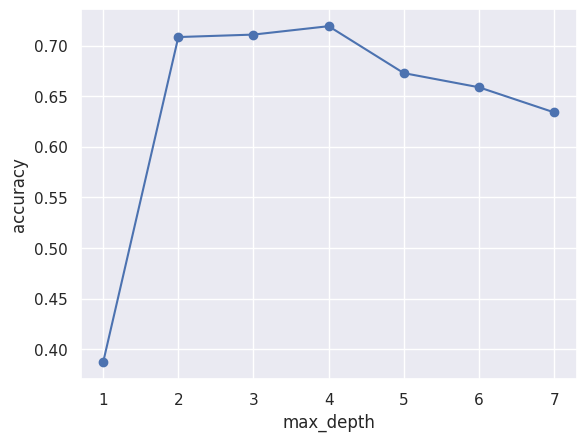

In [6]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) #
accuracies = list()
max_attributes = len(list(spy))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split = 65,
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:3.28}
                                            )
    for train_fold, test_fold in cv.split(spy):
        f_train = spy.loc[train_fold]
        f_test = spy.loc[test_fold]

        model = tree_model.fit( X = f_train.drop(['CLASS'], axis=1),
                               y = f_train['CLASS'])
        test_acc = model.score(X = f_test.drop(['CLASS'], axis=1),
                                y = f_test['CLASS'])
        fold_accuracy.append(test_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

import matplotlib.pyplot as plt
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()


### Ejecución


Ejecutamos todo el proceso de construcción y elaboración del modelo utilizando la máxima profundidad calculada anteriormente y otros parámetros necesarios para mejorar el proceso de predicción.


In [7]:
p_train = 0.75 # .

train = spy[:int((len(spy))*p_train)]
test = spy[int((len(spy))*p_train):]

print("train: ", len(train))
print("tests ", len(test))


features = ['45','75','171']
x_train = train[features]
y_train = train['CLASS']

x_test = test[features]

train:  2087
tests  696


En esta celda se construirá el clasificador, se entrenará el modelo y se hará la predicción sobre los datos de test.

In [8]:
#Constructor/Parametrization
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65,
                                  min_samples_leaf = 20, max_depth = 4,
                                  class_weight={0:3.28})
# fit: training the model
clf.fit(x_train, y_train) # Construcción del modelo

# prediction/test
preds = clf.predict(x_test)

### Resultados

In [9]:
from sklearn.metrics import classification_report
print("Metrics \n"
      +classification_report(y_true=test['CLASS'], y_pred=preds))

# Confussion Matrix
print("Confussion Matrix:\n")
matriz = pd.crosstab(test['CLASS'], preds, rownames=['actual'], colnames=['preds'])
print(matriz)

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)


print(pd.DataFrame({'Feature': features ,
              'Importance': clf.feature_importances_}),"\n")


Metrics 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       166
           1       0.85      0.82      0.83       530

    accuracy                           0.75       696
   macro avg       0.66      0.67      0.67       696
weighted avg       0.76      0.75      0.75       696

Confussion Matrix:

preds    0    1
actual         
0       88   78
1       96  434


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

### Visualización

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [ ]:
from IPython.display import Image

from io import StringIO

dot_data = StringIO()
#tree.export_graphviz(clf, out_file=dot_data, feature_names=list(spy.drop(['CLASIFICADOR'], axis=1)))
tree.export_graphviz(clf, out_file = dot_data, proportion = True,
                     feature_names=list(spy.drop(['CLASS'], axis=1)),
                     class_names = ['0','1'], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())